# Enhancing ZOS API 

In [1]:
import os
import sys
from IPython.display import Image

# Imports for using ZOS API in Python directly with pywin32
from win32com.client.gencache import EnsureDispatch, EnsureModule
from win32com.client import CastTo, constants

# Import for using ZOS API in Python using PyZOS
import pyzos.zos as zos

## Reference

We will use the following two KB articles as base material for this discussion.

* "[How to build and optimize a singlet using ZOS-API with Python](http://www.zemax.com/support/resource-center/knowledgebase/how-to-build-and-optimize-a-singlet-using-zos-api)," Zemax KB, 12/16/2015, Thomas Aumeyr. 

* "[Interfacing to OpticStudio from Mathematica](http://www.zemax.com/support/resource-center/knowledgebase/interfacing-to-opticstudio-from-mathematica)," Zemax KB, 05/03/2015, David.

In [2]:
# Set this variable to True or False to use ZOS API with  
# the PyZOS library or without it respectively.
USE_PYZOS = True

### 1. Initialization of ZOS API Interface and instantiation of an Optical System

In [3]:
if USE_PYZOS:
    osys = zos.OpticalSystem()     # Optical system
else:
    # using ZOS API directly with pywin32
    EnsureModule('ZOSAPI_Interfaces', 0, 1, 0)
    connect = EnsureDispatch('ZOSAPI.ZOSAPI_Connection')
    app = connect.CreateNewApplication() # The Application
    osys = app.PrimarySystem             # Optical system

### 2.  Visibility of property attributes of ZOS object on <kbd>Tab</kbd>

Because of the way property attributes are mapped by PyWin32 library, they are not "visible" on <kbd>Tab</kbd> completion in smart editors such as IPython. Only the methods are shown upon pressing the <kbd>Tab</kbd> (see figure below). Note that although the properties are not "visible" they are still accessible.

PyZOS enhances the user experience by showing both the method and the properties of the ZOS object (actually wrapped). In addition, the properties are easily identified by the prefix `p` in front of the property attribute names.

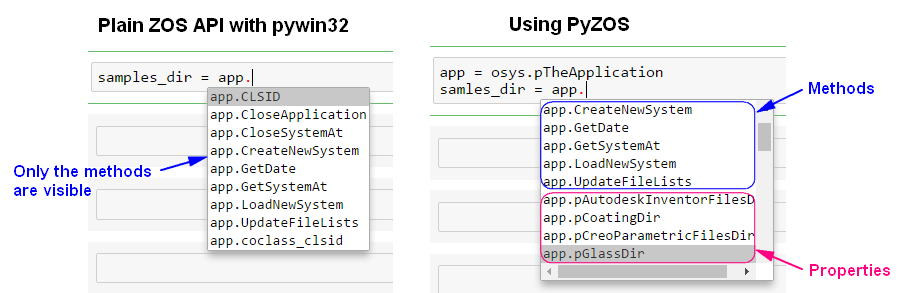

In [4]:
Image('./images/00_01_property_attribute.png')

In [5]:
if USE_PYZOS:
    samples_dir = osys.pTheApplication.pSamplesDir
else:
    samples_dir = osys.TheApplication.SamplesDir


file_out = os.path.join(samples_dir, 'Sequential', 'Ojbectives', 
                       'Single Lens Example wizard+EFFL.zmx')
osys.SaveAs(file_out)

In [6]:
# Aperture
if USE_PYZOS:
    osys_data = osys.pSystemData
    osys_data.pAperture.pApertureValue = 40
else:
    osys_data = osys.SystemData 
    osys_data.Aperture.ApertureValue = 40

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:149: UserWarning: No module isdaperturedata_methods found
  exec(module_import_str, globals(), cdict)


Please don't worry about the ominous looking warning message above (if USE_PYZOS is `True`). It just indicates that the particular ZOS API COM object has been wrapped but PyZOS didn't find any custom method to add to the wrapped class. Currently, the warnings are there to identify and help development of the PyZOS library. The warnings can be easily turned off. 

In [7]:
# Fields
if USE_PYZOS:
    field = osys_data.pFields.AddField(0, 5.0, 1.0)
else:
    field = osys_data.Fields.AddField(0, 5.0, 1.0)

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:149: UserWarning: No module ifield_methods found
  exec(module_import_str, globals(), cdict)


### 3. Visibility of constants on <kbd>Tab</kbd>

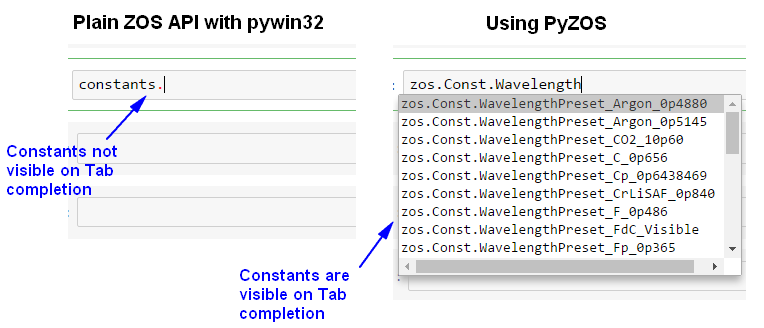

In [9]:
Image('./images/00_02_constants.png')

In [8]:
# Setting wavelength using wavelength preset
if USE_PYZOS:
    osys_data.pWavelengths.SelectWavelengthPreset(zos.Const.WavelengthPreset_d_0p587);
else:
    osys_data.Wavelengths.SelectWavelengthPreset(constants.WavelengthPreset_d_0p587);


C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:149: UserWarning: No module iwavelengths_methods found
  exec(module_import_str, globals(), cdict)


True

In [2]:

# Lens data
lde = osys.LDE
lde.InsertNewSurfaceAt(1)
lde.InsertNewSurfaceAt(1)
surf1 = lde.GetSurfaceAt(1)
surf2 = lde.GetSurfaceAt(2)
surf3 = lde.GetSurfaceAt(3)
surf1.Thickness = 10.0
surf1.Comment = 'front of lens'
surf1.Material = 'N-BK7'
surf2.Thickness = 50.0
surf2.Comment = 'rear of lens'
surf3.Thickness = 350.0
surf3.Comment = 'Stop is free to move'

# Setting solves - Made thickness and radii variable
surf1.ThicknessCell.MakeSolveVariable()
surf2.RadiusCell.MakeSolveVariable()
surf2.ThicknessCell.MakeSolveVariable()
surf3.ThicknessCell.MakeSolveVariable()

# Setting up the default merit function 
mfe = osys.MFE
wizard = mfe.SEQOptimizationWizard
wizard.Type = 0          # RMS
wizard.Data = 1          # Spot Radius
wizard.Reference = 0     # Centroid
wizard.Ring = 2          # 3 Rings
wizard.Arm = 0           # 6 Arms
wizard.IsGlassUsed = True
wizard.GlassMin = 3
wizard.GlassMax = 15
wizard.GlassEdge = 3
wizard.IsAirUsed = True
wizard.AirMin = 0.5
wizard.AirMax = 1000
wizard.AirEdge = 0.5
wizard.IsAssumeAxialSymmetryUsed = True
wizard.CommonSettings.OK()

operand1 = mfe.InsertNewOperandAt(1)
operand1.ChangeType(constants.MeritOperandType_EFFL)
operand1.Target = 400.0
operand1.Weight = 1.0

# Local optimization
local_opt = osys.Tools.OpenLocalOptimization()
local_opt.Algorithm = constants.OptimizationAlgorithm_DampedLeastSquares
local_opt.Cycles = constants.OptimizationCycles_Automatic
local_opt.NumberOfCores = 8
base_tool = CastTo(local_opt, 'ISystemTool')
base_tool.RunAndWaitForCompletion()
base_tool.Close()

# save
osys.Save()
app.CloseApplication()
del app